In [1]:
import numpy as np
import math
#来自文献 Verifying explainability of a deep learning tissue classifier trained on RNA-seq data project
#https://github.com/ktrannt/GradientExplainer-RNAseq
#
def convert_2d(df):
    np_array = df.values
    pixel_length = math.ceil(math.sqrt(df.shape[1]))  #将一维特征数量开平方并向上取整得到要转换的二维矩阵的长度
    pad_length = pixel_length ** 2 - df.shape[1]  #计算需要填充0的长度
    np_array_padded = np.pad(np_array, ((0, 0), (0, pad_length)), mode="constant")
    np_array_2d = np.reshape(
        np_array_padded, (np_array_padded.shape[0], pixel_length, pixel_length)
    )
    np_array_2d_1 = np.expand_dims(np_array_2d, axis=3)
    return np_array_2d_1



In [68]:
#加载数据和标签，划分训练集和测试集后再按染色体划分成要输入的模型的数据
#每条染色体有独立的特征提取器
#多个输入以适应染色体的不同大小
import h5py
# import re
import pickle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

group_id = 'compartment_raw'
df = '/home/notebook/scCompartment_cortex250k.hdf5'
file = h5py.File(df, 'r')
bin_chr = np.array([chrom.decode('utf-8') for chrom in file['compartment_raw']['bin']['chrom']])

cell_keys = list(filter(lambda key: 'cell_' in key, file[group_id].keys()))
cell_list_len=len(cell_keys)

datasets = [file[group_id][f'cell_{i}'][()] for i in range(cell_list_len)]
data = pd.DataFrame({f'cell_{i}': dataset for i, dataset in enumerate(datasets)})
# chr_list = list(np.unique(bin_chr))
# chr_list.sort(key=lambda l: int(re.findall('\d+', l)[0]))
# chr_list = ["chr1","chr2","chr3","chr4","chr5",
#     "chr6","chr7","chr8","chr9","chr10",
#     "chr11","chr12","chr13","chr14","chr15",
#     "chr16","chr17","chr18","chr19"]
chr_list = ["chr1","chr2","chr3"]
chr_index ={}
# chr_data =[]
print(chr_list)
for i in range(len(chr_list)):
    chr_index[i] = np.where(bin_chr == chr_list[i])[0]
    # temp_data =data.iloc[chr_index[i], :]
    # chr_data.append(temp_data)


label_path = '/home/notebook/label_info.pickle'
y=pickle.load(open(label_path, "rb"))
print(f"Label file to load: {label_path}")
label=pd.DataFrame()
label['cell_id']= data.columns
label['cell_type']=y['cell_type']


data_np=np.array(data.T)
label_encoder = LabelEncoder()
indexed_labels = label_encoder.fit_transform(label['cell_type'].values)
onehot_encoder = OneHotEncoder(sparse=False)
encoded_labels = onehot_encoder.fit_transform(indexed_labels.reshape(-1, 1))
encoded_labels_df = pd.DataFrame(encoded_labels, columns=[f'_{i}' for i in range(encoded_labels.shape[1])])
X_train, X_test, y_train, y_test = train_test_split(data_np, encoded_labels_df, test_size=0.2, random_state=123)

['chr1', 'chr2', 'chr3']
Label file to load: /home/notebook/label_info.pickle


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [16]:
convert_2d(pd.DataFrame(X_test[:,chr_index[0]])).shape[1:]

(28, 28, 1)

In [69]:
train_dataset =[]
test_dataset = []
input_shapes_list =[]
for i in range(len(chr_list)):
# for i in range(2):
    # train_dataset.append(X_train_3d[:,chr_index[i],:])
    # input_shapes_list.append(X_train_3d[:,chr_index[i],:].shape[1:])
    # test_dataset.append(X_test_3d[:,chr_index[i],:])
    train_dataset.append(convert_2d(pd.DataFrame(X_train[:,chr_index[i]])))
    input_shapes_list.append(convert_2d(pd.DataFrame(X_train[:,chr_index[i]])).shape[1:])
    test_dataset.append(convert_2d(pd.DataFrame(X_test[:,chr_index[i]])))
dataset = (train_dataset,y_train,test_dataset,y_test) 

In [70]:
input_shapes_list

[(28, 28, 1), (27, 27, 1), (26, 26, 1)]

In [19]:
# Deep Neural Networks:
import tensorflow as tf; print('We\'re using TF-{}.'.format(tf.__version__))
# import keras; print('We\'re using Keras-{}.'.format(keras.__version__))
from keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate)
from keras.regularizers import (l1, l2, l1_l2)
from keras.optimizers import (RMSprop, Adam, SGD)
from keras.models import (Sequential, Model)

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
import matplotlib.patches as patches

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, matthews_corrcoef, precision_score, roc_curve, auc)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)

#Utilities:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical as labelEncoding
from keras.utils import plot_model  
 

2024-01-09 06:17:54.863352: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 06:17:54.909470: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 06:17:54.909523: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 06:17:54.909552: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 06:17:54.920194: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 06:17:54.920880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

We're using TF-2.14.0.


In [72]:
def Network(input_shapes):
    inputs = []
    heads = []

    # Create input layers for each head
    for input_shape in input_shapes:

        input_layer = Input(shape=input_shape)
        inputs.append(input_layer)

        x = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(input_layer)
        x = MaxPooling2D(2,2)(x)
        x = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
        x = MaxPooling2D(2,2)(x)
        head = Flatten()(x)
        heads.append(head)

    # Concatenate all heads
    merge = Concatenate()(heads)

    output = Dense(units=3, activation='softmax')(merge)

    return Model(inputs=inputs, outputs=output)

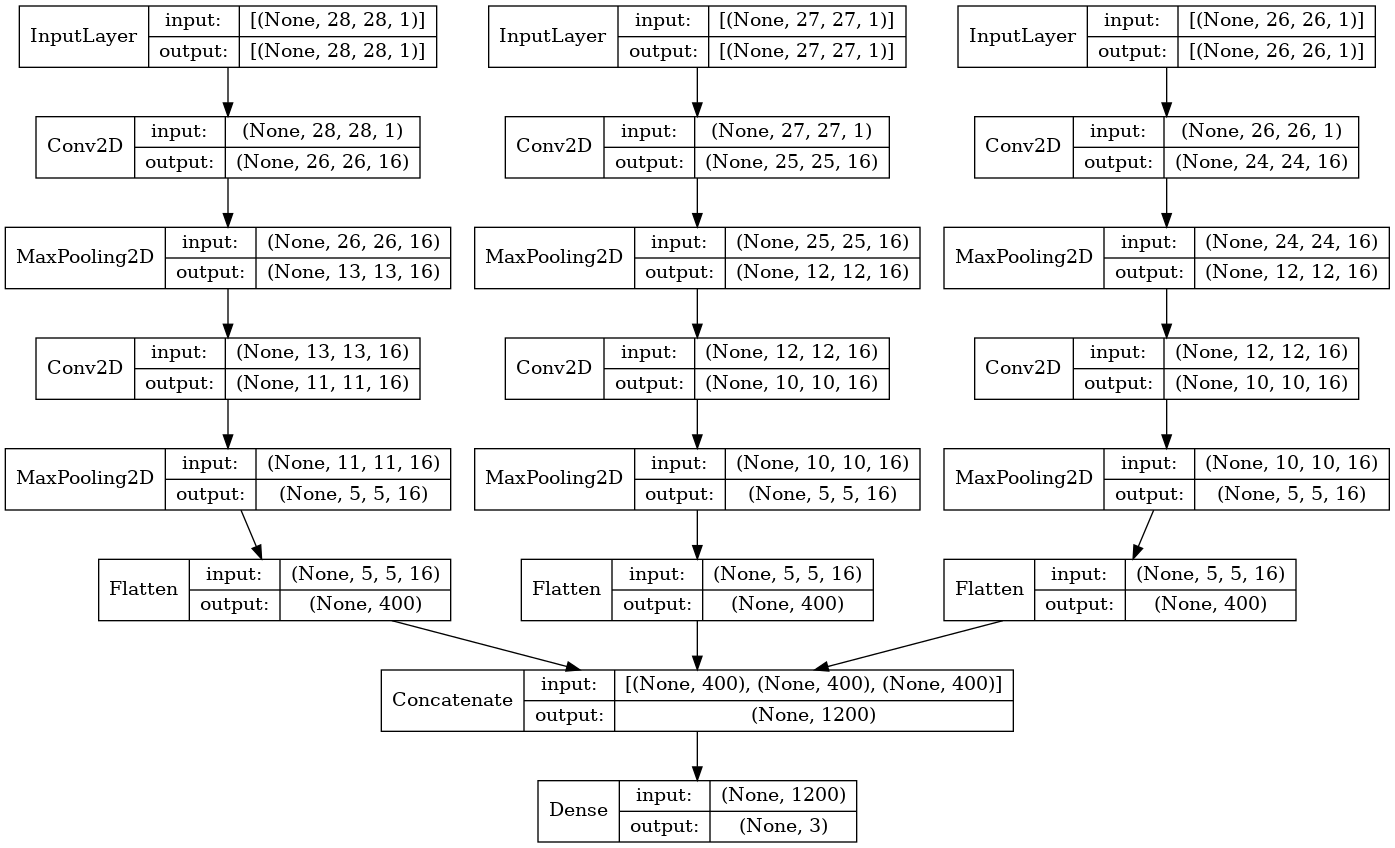

In [73]:
model = Network(input_shapes=input_shapes_list)
# model.summary()
plot_model(model, to_file='model-chr1-chr2_2d.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [74]:
x_train_1=convert_2d(pd.DataFrame(X_train[:,chr_index[0]]))
x_train_2=convert_2d(pd.DataFrame(X_train[:,chr_index[1]]))

x_train_3=convert_2d(pd.DataFrame(X_train[:,chr_index[2]]))

x_test_1 = convert_2d(pd.DataFrame(X_test[:,chr_index[0]]))
x_test_2 = convert_2d(pd.DataFrame(X_test[:,chr_index[1]]))
x_test_3 = convert_2d(pd.DataFrame(X_test[:,chr_index[2]]))




In [75]:
model.compile(loss='categorical_crossentropy', optimizer="adam",
                metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss',  
#                             mode='min',          
#                             patience=5,          
#                             verbose=1)

# model.fit(X_train_3d, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_3d, y_test), callbacks=[early_stopping])
# _, accuracy = model.evaluate(X_test_3d, y_test)
model.fit([x_train_1, x_train_2, x_train_3],y_train, epochs=3, validation_data=([x_test_1,x_test_2,x_test_3], y_test))

_, accuracy = model.evaluate([x_test_1,x_test_2,x_test_3], y_test)
print('Accuracy: %.2f%%' % (accuracy * 100))

Epoch 1/3
27/27 [==============================] - 3s 23ms/step - loss: 1.0515 - accuracy: 0.4453 - val_loss: 0.9866 - val_accuracy: 0.4465
Epoch 2/3
27/27 [==============================] - 0s 14ms/step - loss: 0.9305 - accuracy: 0.5058 - val_loss: 0.9733 - val_accuracy: 0.4977
Epoch 3/3
7/7 [==============================] - 0s 5ms/step - loss: 0.8951 - accuracy: 0.6326
Accuracy: 63.26%


In [76]:
import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, [x_train_1, x_train_2, x_train_3])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([x_test_1[:3], x_test_2[:3],x_test_3[:3]])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [88]:
x_test_1[:1].shape

(1, 28, 28, 1)

In [87]:
X_train_3d, y_train, X_test_3d ,y_test=dataset

In [94]:
test_dataset[0][:1].shape

(1, 28, 28, 1)

In [78]:
x_test_3[:3].shape

(3, 26, 26, 1)

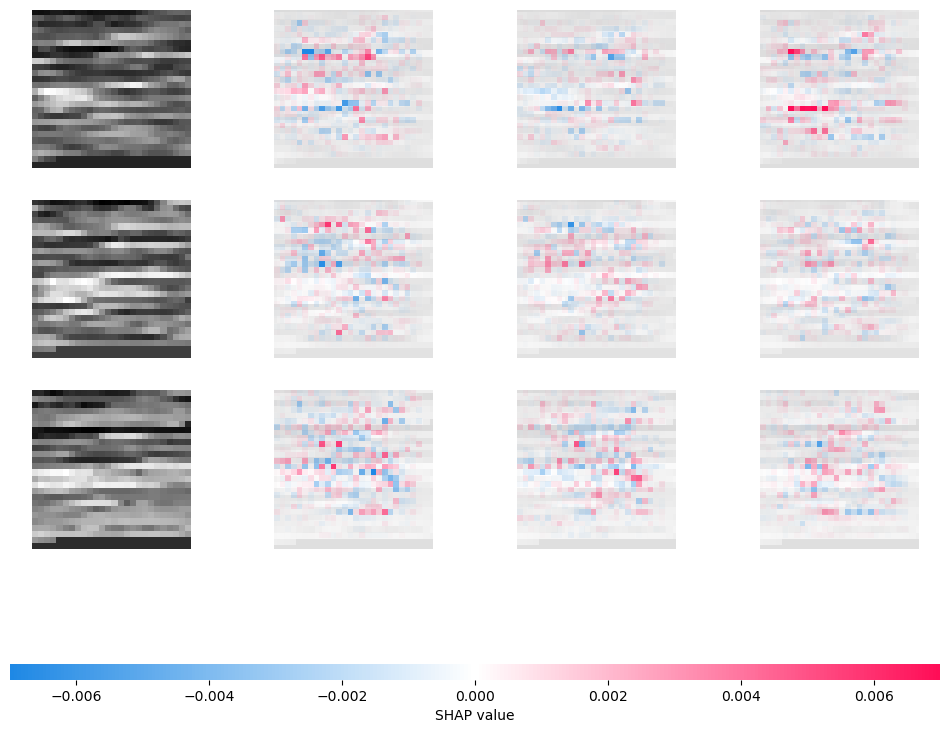

In [81]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
shap.image_plot([shap_values[i][0] for i in range(3)], x_test_3[:3])

In [41]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [42]:
# Optimizer=Adam(learning_rate=0.001)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
# model.compile(loss='categorical_crossentropy', optimizer=Optimizer, 
#                 metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  
                            mode='min',          
                            patience=5,          
                            verbose=1)

# model.fit(X_train_3d, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_3d, y_test), callbacks=[early_stopping])
# _, accuracy = model.evaluate(X_test_3d, y_test)
# model.fit([x_train, x_train], y_train, epochs=1)
model.fit([x_train, x_train],y_train, epochs=3, validation_data=([x_test,x_test], y_test))

_, accuracy = model.evaluate([x_test,x_test], y_test)
print('Accuracy: %.2f%%' % (accuracy * 100))

Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.1952 - accuracy: 0.9429 - val_loss: 0.0618 - val_accuracy: 0.9797
Epoch 2/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0663 - accuracy: 0.9804 - val_loss: 0.0591 - val_accuracy: 0.9815
Epoch 3/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0499 - accuracy: 0.9846 - val_loss: 0.0458 - val_accuracy: 0.9842
Epoch 4/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0409 - accuracy: 0.9877 - val_loss: 0.0350 - val_accuracy: 0.9872
Epoch 5/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0341 - accuracy: 0.9892 - val_loss: 0.0340 - val_accuracy: 0.9885
Epoch 6/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0294 - accuracy: 0.9910 - val_loss: 0.0379 - val_accuracy: 0.9875
Epoch 7/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0248 - accuracy: 0.9919 - val_loss: 0.0301 - 

In [43]:
import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, [x_train, x_train])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([x_test[:3], x_test[:3]])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


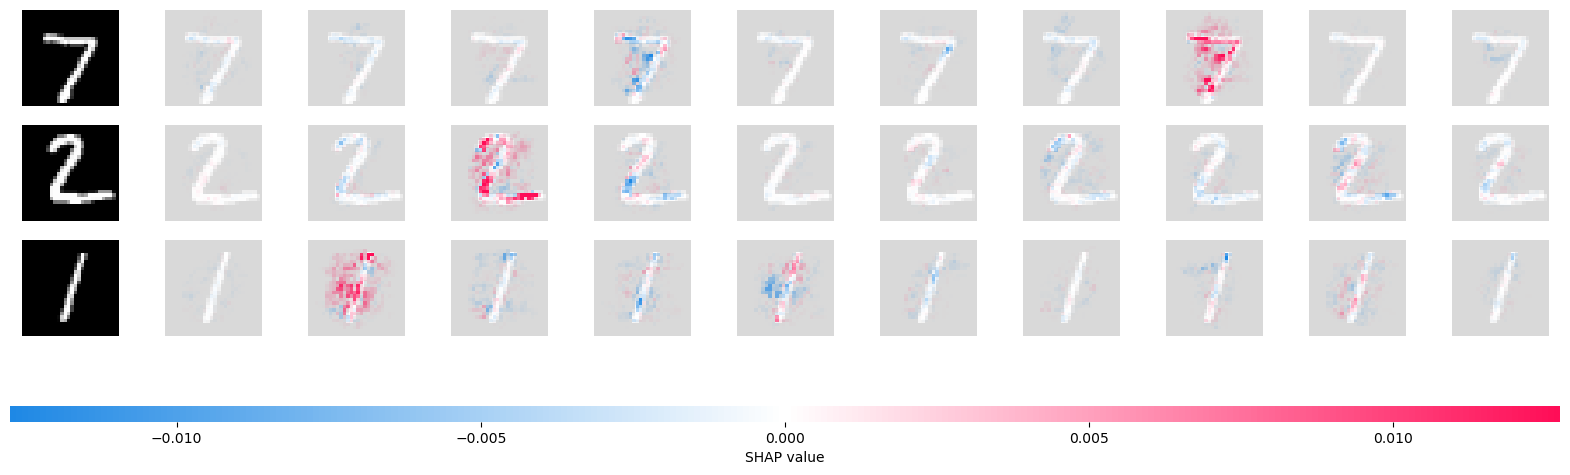

In [44]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
shap.image_plot([shap_values[i][0] for i in range(10)], x_test[:3])

In [26]:
def train(model,dataset,epochs,batch_size,lr):
    Optimizer=Adam(learning_rate=lr)
    X_train_3d, y_train, X_test_3d ,y_test=dataset
    
    model.compile(loss='categorical_crossentropy', optimizer=Optimizer, 
                    metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss',  
                                mode='min',          
                                patience=5,          
                                verbose=1)

    # model.fit(X_train_3d, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_3d, y_test), callbacks=[early_stopping])
    # _, accuracy = model.evaluate(X_test_3d, y_test)
    model.fit(X_train_3d, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_3d, y_test))
    _, accuracy = model.evaluate(X_test_3d, y_test)
    print('Accuracy: %.2f%%' % (accuracy * 100))
    # model.save("test_model.h5")

    return model

epochs =30
batch_size = 16
lr = 0.001

train(model,dataset,epochs,batch_size,lr)

Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/local/anaconda/envs/hic/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/usr/local/anaconda/envs/hic/lib/python3.9/runpy.py", line 87, in _run_code

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/local/anaconda/envs/hic/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/usr/local/anaconda/envs/hic/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/usr/local/anaconda/envs/hic/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code

  File "/tmp/ipykernel_31705/3179378529.py", line 27, in <cell line: 27>

  File "/tmp/ipykernel_31705/3179378529.py", line 16, in train

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/engine/training.py", line 1127, in train_step

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/engine/training.py", line 1185, in compute_loss

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/keras/src/backend.py", line 5777, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [16,3] and labels shape [48]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_12492]

In [24]:
train_dataset[0][1].shape

(28, 28, 1)

In [23]:
import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, [train_dataset[0][1], train_dataset[1][1]])

# we explain the model's predictions on the first three samples of the test set
# shap_values = explainer.shap_values([test_dataset[0][1], test_dataset[1][1]])

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


ValueError: cannot reshape array of size 1400 into shape (28,28,1)

In [5]:
X_train.shape[1]

10283

In [7]:
x_2d = convert_2d(pd.DataFrame(X_train))

In [9]:
x_2d.shape

(860, 102, 102, 1)